In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import wfdb
import os
from time import time as time
from tqdm import tqdm
import copy
from scipy import signal
import pickle
import ast
from torch import nn
import torch
from functools import reduce
from operator import __add__
import torch.nn.functional as F
from torchmetrics.classification import MultilabelF1Score,MultilabelPrecision,MultilabelRecall,MultilabelAccuracy
import pickle 

import models


In [2]:
os.chdir('/athena/sablab/scratch/prj4005/XML')

In [3]:
csv = pd.read_csv('physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv')
root_dir = 'physionet.org/files/ptb-xl/1.0.3'

In [4]:
class PTBDataset(Dataset):
  def __init__(
      self,
      csv = 'physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv',
      root_dir = 'physionet.org/files/ptb-xl/1.0.3',
      scp_csv = 'physionet.org/files/ptb-xl/1.0.3/scp_statements.csv',
      mode = 'append'):
    df = pd.read_csv(csv)
    
    self.root_dir = root_dir
    self.mode = mode
    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv(scp_csv, index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]
    def aggregate_diagnostic(y_dic):
      tmp = []
      for key in y_dic.keys():
          if key in agg_df.index:
              tmp.append(agg_df.loc[key].diagnostic_class)
      
      return list(set(tmp))

    df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
    df['diagnostic_superclass'] = df.scp_codes.apply(aggregate_diagnostic)
    self.data = df
    
    index = np.where(self.data.strat_fold.isin([0,1,2,3,4,5,6,7,8]))
    self.train = self.data.iloc[index]
    index = np.where(self.data.strat_fold.isin([9]))
    self.val = self.data.iloc[index]
    index = np.where(self.data.strat_fold.isin([10]))
    self.test = self.data.iloc[index]

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.toint()
    fname_1 = self.root_dir+os.sep+self.data.iloc[idx].filename_lr
    sample_1,head = wfdb.rdsamp(str(fname_1))
    label_1 = self.data["diagnostic_superclass"].iloc[idx]
    label = np.zeros(5,dtype = np.int64)
    dic = {'NORM':0,'MI':1,'STTC':2,'CD':3,'HYP':4}
    for i in label_1:
      label[dic[i]] = 1
    return np.squeeze(sample_1),label

  def set_fold(self,fold):
    if fold == "Train":
      self.data = self.train
    elif fold == "Val":
      self.data = self.val
    elif fold == "Test":
      self.data = self.test
    else:
      raise Exception(f"No fold named: {fold}")
    return self

  

NameError: name 'dataset' is not defined

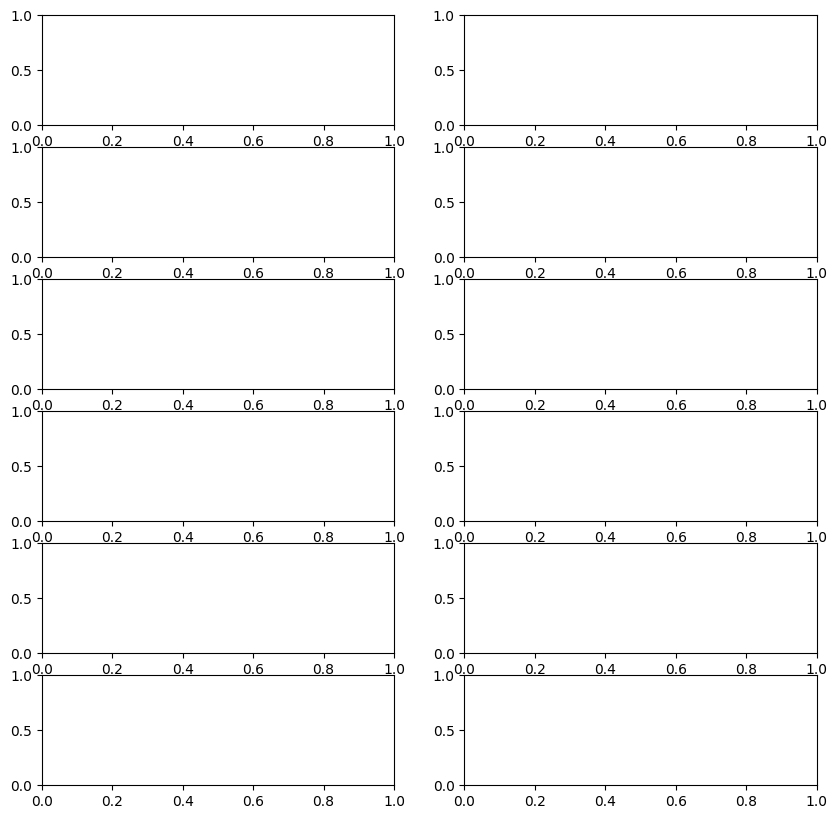

In [4]:
fig,ax = plt.subplots(6,2,figsize=(10,10))
chan = {0:'I',1:'II',2:'III',3:'aVL',4:'aVR',5:'aVF',6:'V1',7:'V2',8:'V3',9:'V4',10:'V5',11:'V6'}
for i in range(12):
    ax[i-6*(i//6)][i//6].plot(dataset[7][0][:,i])
    ax[i-6*(i//6)][i//6].set_title(f'Channel {chan[i]}')


fig.tight_layout()

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device= torch.device('cuda')):
    since = time()
    val_acc_history = []
    train_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model = model.to(device)
    Accuracy = MultilabelAccuracy(num_labels=5,average='macro').to(device)
    F1 = MultilabelF1Score(num_labels=5, average='macro').to(device)
    Precision = MultilabelPrecision(num_labels=5, average='macro').to(device)
    Recall = MultilabelRecall(num_labels=5, average='macro').to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_acc = 0
            running_corrects = 0
            running_f1 = 0
            running_precision = 0
            running_recall = 0

            # Iterate over data.
            for input,label in tqdm(dataloaders[phase]):
                input = input.to(device=device, dtype=torch.float).permute(0,2,1)
                label = label.to(device=device, dtype=torch.float)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss                    
                    outputs = model(input)
                    loss = criterion(outputs, label)
                    #Predictions from Binary Cross Entropy with Logits

                    preds = torch.squeeze(torch.sigmoid(outputs))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # statistics
                running_loss += loss.item() * input.size(0)
                running_acc += Accuracy(preds, label.data) * input.size(0)
                running_f1 += F1(preds, label.data) * input.size(0)
                running_precision += Precision(preds, label.data) * input.size(0)
                running_recall += Recall(preds, label.data) * input.size(0)
                
                running_corrects += torch.sum(preds == label.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_acc / len(dataloaders[phase].dataset)
            epoch_f1 = running_f1 / len(dataloaders[phase].dataset)
            epoch_precision = running_precision / len(dataloaders[phase].dataset)
            epoch_recall = running_recall / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} F1: {:.4f} Precision: {:.4f} Recall: {:.4f}'.format(phase, epoch_f1, epoch_precision, epoch_recall))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [6]:
batch_size = 32
train_data = PTBDataset()
train_data = train_data.set_fold("Train")
val_data = PTBDataset()
val_data = val_data.set_fold("Val")
test_data = PTBDataset()
test_data = test_data.set_fold("Test")
trainLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

valLoader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

dataloaders = {'train':trainLoader,'val':valLoader,'test':testLoader}




In [7]:
import importlib
importlib.reload(models)

<module 'models' from '/athena/sablab/scratch/prj4005/XML/models.py'>

In [8]:
weights = np.array([9514,5469,5235,4898,2649])
weights = (21801-weights)/weights
print(weights)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights).float().to('cuda'))
# mod = models.resnetsmall(pretrained= False, num_classes = 5)
optimizer = torch.optim.Adam(mod.parameters(),lr=0.05,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)

[1.29146521 2.98628634 3.16446991 3.45100041 7.22989807]


RuntimeError: CUDA error: out of memory

In [ ]:
mod, val_acc_history, train_acc_history = train_model(mod, dataloaders, criterion, optimizer, num_epochs = 50, device = torch.device('cuda'))

In [128]:
import time as t

In [129]:
meta = f'Resnetsmall_{t.ctime().replace(" ","_")}'
pickle.dump(mod, open(f"{meta}_model.pkl", "wb"))
pickle.dump(val_acc_history, open(f"{meta}_val_acc_history.pkl", "wb"))
pickle.dump(train_acc_history, open(f"{meta}_train_acc_history.pkl", "wb"))

In [11]:
def infer_omodel(model, dataloaders, criterion, optimizer, device= torch.device('cuda')):

    model = model.to(device)
    train_preds = []
    train_labels = []
    val_preds = []
    val_labels = []
    test_preds = []
    test_labels = []
    model.eval()

    # Each epoch has a training and validation phase
    for phase in ['test']:
        # Iterate over data.
        for input,label in tqdm(dataloaders[phase]):
            input = input.to(device=device, dtype=torch.float).permute(0,2,1)
            label = label.to(device=device, dtype=torch.float)
    
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                # Get model outputs and calculate loss                    
                outputs = model(input)
                preds = torch.squeeze(torch.sigmoid(outputs))
            if phase == 'train':
                train_preds.append(preds)
                train_labels.append(label)
            elif phase == 'val':
                val_preds.append(preds)
                val_labels.append(label)
            elif phase == 'test':
                test_preds.append(preds)
                test_labels.append(label)
                

    return model, train_preds, train_labels, val_preds, val_labels, test_preds, test_labels

In [8]:
meta = '/athena/sablab/scratch/prj4005/XML/Resnetsmall_Fri_Apr_28_10:21:11_2023'
mod = pickle.load(open(f"{meta}_model.pkl", "rb"))
val_acc_history = pickle.load(open(f"{meta}_val_acc_history.pkl", "rb"))
train_acc_history = pickle.load(open(f"{meta}_train_acc_history.pkl", "rb"))
weights = np.array([9514,5469,5235,4898,2649])
weights = (21801-weights)/weights
print(weights)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights).float().to('cuda'))
# mod = models.resnetsmall(pretrained= False, num_classes = 5)
optimizer = torch.optim.Adam(mod.parameters(),lr=0.05,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)



[1.29146521 2.98628634 3.16446991 3.45100041 7.22989807]


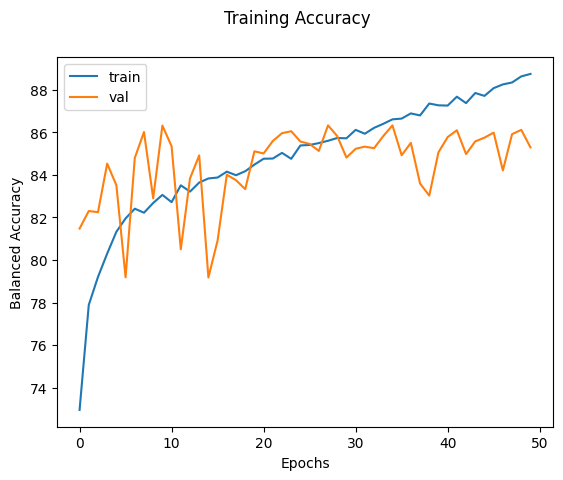

In [39]:
fig,ax = plt.subplots(1)
fig.suptitle('Training Accuracy')
ax.plot(torch.tensor(train_acc_history).cpu().numpy()*100, label='train')
ax.plot(torch.tensor(val_acc_history).cpu().numpy()*100, label='val')
ax.set_xlabel('Epochs')
ax.set_ylabel('Balanced Accuracy')
ax.legend()

In [12]:
mod, train_preds, train_labels, val_preds, val_labels, test_preds,test_labels = infer_omodel(mod, dataloaders, criterion, optimizer, device= torch.device('cuda'))

100%|███████████████████████████████████████████| 69/69 [00:08<00:00,  8.00it/s]


In [13]:
# train_labels = torch.cat(train_labels)
# train_preds = torch.cat(train_preds)
# val_labels = torch.cat(val_labels)
# val_preds = torch.cat(val_preds)
test_labels = torch.cat(test_labels)
test_preds = torch.cat(test_preds)

In [14]:

weighted_accuracy = torch.mean(torch.sum(torch.round(test_preds) == test_labels,dim =0)/test_labels.shape[0])
print(weighted_accuracy)

tensor(0.8641, device='cuda:0')


In [15]:
print(torch.round(test_preds))

tensor([[0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0.]], device='cuda:0')


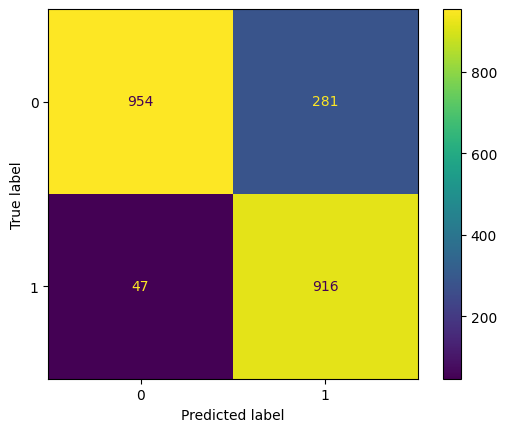

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay,multilabel_confusion_matrix
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(task="multilabel", num_labels=5)
cm = confmat(torch.round(test_preds).type(torch.int).to('cpu'), test_labels.type(torch.int).to('cpu'))
cm = cm.cpu().numpy()
ConfusionMatrixDisplay(cm[0], display_labels = ['0','1']).plot()


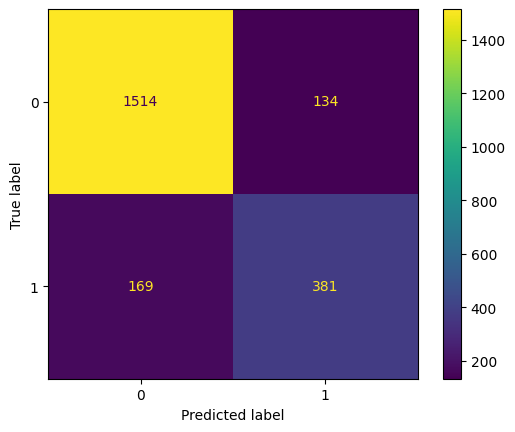

In [16]:
ConfusionMatrixDisplay(cm[1], display_labels = ['0','1']).plot()


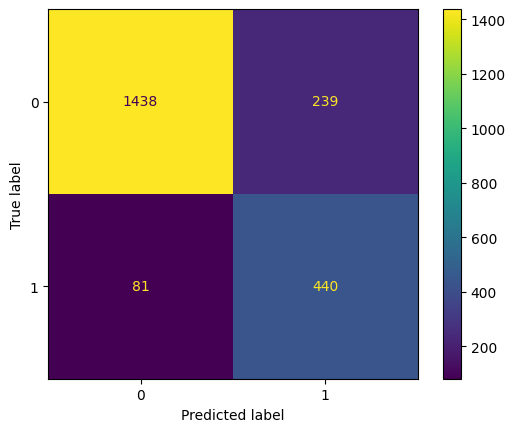

In [17]:
ConfusionMatrixDisplay(cm[2], display_labels = ['0','1']).plot()


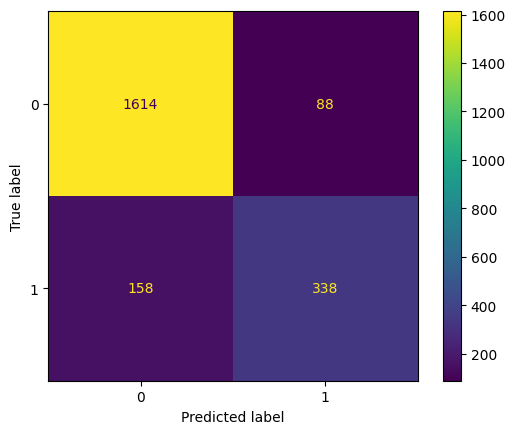

In [18]:
ConfusionMatrixDisplay(cm[3], display_labels = ['0','1']).plot()


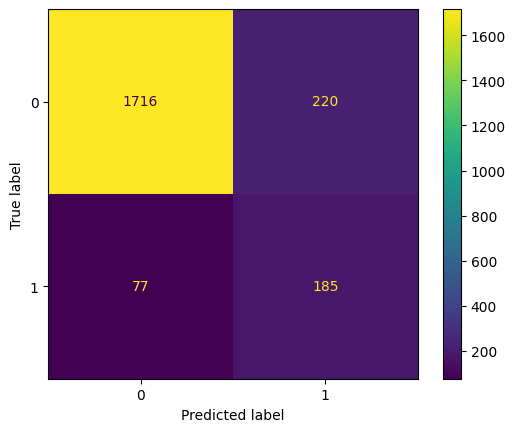

In [19]:
ConfusionMatrixDisplay(cm[4], display_labels = ['0','1']).plot()


In [25]:
device = 'cuda'
from torchmetrics.classification import MultilabelAUROC
auroc = MultilabelAUROC(num_labels=5, average='macro')

Accuracy = MultilabelAccuracy(num_labels=5,average='macro').to(device)
F1 = MultilabelF1Score(num_labels=5, average='macro').to(device)
Precision = MultilabelPrecision(num_labels=5, average='macro').to(device)
Recall = MultilabelRecall(num_labels=5, average='macro').to(device)
print(f'Auroc: {auroc(torch.round(test_preds), test_labels.int())}')
print(f'F1: {F1(torch.round(test_preds), test_labels.int())}')
print(f'Precision: {Precision(torch.round(test_preds), test_labels.int())}')
print(f'Recall: {Recall(torch.round(test_preds), test_labels.int())}')


Auroc: 0.8259312510490417
F1: 0.7169772386550903
Precision: 0.6806563138961792
Recall: 0.7752019166946411


In [11]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

gradients  = {}
def getGradients(name):
    def hook(model, input, output):
        gradients[name] = output
    return hook

torch.Size([1, 1000, 12])


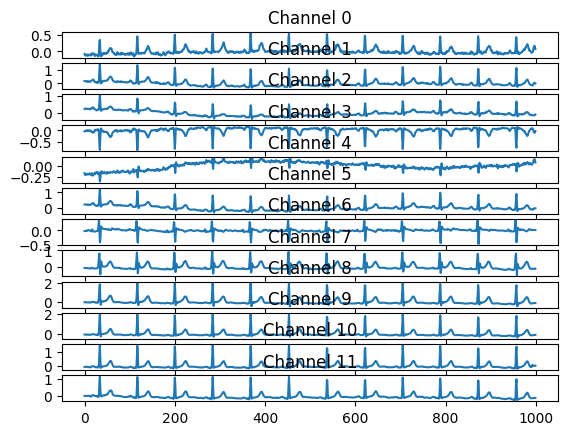

In [85]:
input,label = data_iter.next()
print(input.shape)
input = input.permute(0,2,1)
fig,ax = plt.subplots(12,1)
for i in range(12):
    ax[i].plot(input[0,i].cpu().numpy())
    ax[i].set_title(f'Channel {i}')

In [31]:


# a dict to store the activations



In [17]:
# a dict to store the activations
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

gradients  = {}
def getGradients(name):
    def hook(model, input, output):
        gradients[name] = output
    return hook
def guided_gradcam(mod,input,i):
    h0=mod.layer4[0].relu.register_forward_hook(getActivation('layer0'))
    g0=mod.layer4[0].relu.register_backward_hook(getGradients('layer0'))
    input = torch.tensor(input).permute(0,2,1).type(torch.FloatTensor).to(torch.device('cuda'))
    input.requires_grad = True
    pred = mod(input)
    pred[0][i].backward(retain_graph=True)
    h0.remove()
    g0.remove()
    pooled_gradients = torch.mean(gradients['layer0'][0], dim=[0, 2])
    channels = activation['layer0'].shape[1]
    for i in range(channels):
        activation['layer0'][0,i] *= pooled_gradients[i]
    heatmap = torch.mean(activation['layer0'][0], dim=0).cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    print(heatmap.shape)
    heatmap = signal.resample(heatmap, 1000)


        
    x = input.grad
    x = x.cpu().numpy()
    guided_out = x
    guided_out = np.maximum(guided_out, 0)
    input = input.detach().cpu().numpy()
    pred = 1/(1+torch.exp(-pred))

    return input, guided_out,heatmap,pred


/tmp/ipykernel_275033/84068340.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input).permute(0,2,1).type(torch.FloatTensor).to(torch.device('cuda'))


/scratch/prj4005_3605395/ipykernel_184507/1672654905.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input).permute(0,2,1).type(torch.FloatTensor).to(torch.device('cuda'))


(32,)


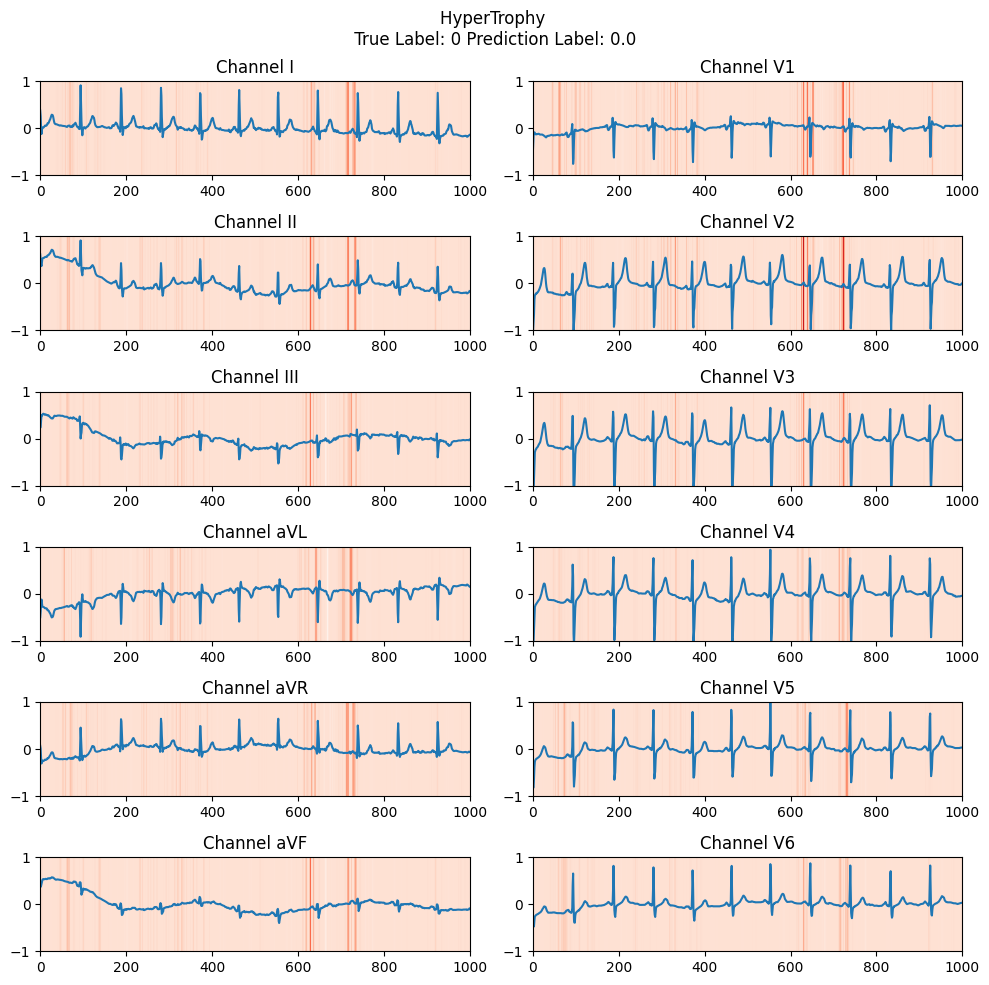

In [36]:
testLoader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                            shuffle=True, num_workers=2)
data_iter = iter(testLoader)
i= 4
input,label = data_iter.next()
input, guided_out,heatmap, pred = guided_gradcam(mod,input,i)
guided_out = np.sum(guided_out,axis = 0)
guided_grad = guided_out*heatmap[None,:]
Channels = {0:'I',1:'II',2:'III',3:'aVL',4:'aVR',5:'aVF',6:'V1',7:'V2',8:'V3',9:'V4',10:'V5',11:'V6'}
fig,ax = plt.subplots(6,2,figsize=(10,10))
fig.suptitle(f'HyperTrophy \n True Label: {label[0][i]} Prediction Label: {torch.round(pred[0][i])} ')
vmin = np.min(guided_grad)
vmax = np.max(guided_grad)
for i in range(12):
    ax[i-6*(i//6)][i//6].plot(input[0,i])
    ax[i-6*(i//6)][i//6].set_title(f'Channel {Channels[i]}')
    ax[i-6*(i//6)][i//6].imshow(np.expand_dims(guided_out[i,:]*heatmap,axis = 0),cmap='Reds', aspect="auto", extent=[0, 1000,-1,1],vmin = vmin, vmax = vmax)
fig.tight_layout()
    

In [29]:
print(mod.layer4[0].relu)

ReLU(inplace=True)


In [21]:
df = dataset.data['diagnostic_superclass']

In [23]:
df['Norm'] = df.diagnostic_superclass['Normal']

AttributeError: 'Series' object has no attribute 'diagnostic_superclass'

In [24]:
csv = 'physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv'
root_dir = 'physionet.org/files/ptb-xl/1.0.3'
scp_csv = 'physionet.org/files/ptb-xl/1.0.3/scp_statements.csv'
dic = {'NORM':0,'MI':1,'STTC':2,'CD':3,'HYP':4}
df = pd.read_csv(csv)
agg_df = pd.read_csv(scp_csv, index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
def aggregate_diagnostic(y_dic):
      tmp = 0
      for key in y_dic.keys():
          if key in agg_df.index:
              if agg_df.loc[key].diagnostic_class == key_set:
                tmp  = 1

      
      return tmp

df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
for key_set in dic.keys():
    df[key_set] = df.scp_codes.apply(aggregate_diagnostic)

In [95]:
Mi_indices = df[df['MI'] == 1].index

In [96]:
Mi_indices

Int64Index([    7,    38,    49,    62,    76,   102,   105,   130,   138,
              144,
            ...
            21757, 21760, 21766, 21772, 21776, 21781, 21785, 21787, 21788,
            21789],
           dtype='int64', length=5469)